In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
%pylab inline
%qtconsole
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Load Data table

In [2]:
# load data table
Predtbl = pd.read_csv('DataSample.csv','\t')
#Predtbl['sbj']     = Predtbl['sbj'].astype('category')
#Predtbl['trial']   = Predtbl['trial'].astype('category')

isbj    = 1
sbjtbl  = Predtbl[Predtbl.sbj == isbj]

# Preprocess

In [3]:
# registrate fixation by their spatial location
nitem,_ = sbjtbl.shape
xfix    = np.asarray(sbjtbl['xfix'])
yfix    = np.asarray(sbjtbl['yfix'])

# leftrect1,leftrect2,leftrect3,leftrect4,rightrect1,rightrect2,rightrect3,rightrect4 \
# = np.asarray(sbjtbl.iloc[0,13:21])
loc     = np.zeros(nitem)
index1  = [(sbjtbl['leftrect1'] < xfix) * (sbjtbl['leftrect3'] > xfix) *\
          (sbjtbl['leftrect2'] < yfix) * (sbjtbl['leftrect4'] > yfix)]
loc[np.where(index1)[1]] = -1 # left stimulus
index2  = [(sbjtbl['rightrect1'] < xfix) * (sbjtbl['rightrect3'] > xfix) *\
          (sbjtbl['rightrect2'] < yfix) * (sbjtbl['rightrect4'] > yfix)]
loc[np.where(index2)[1]] = 1 # right stimulus

trialall = np.asarray([sbjtbl.sbj-1])*[sbjtbl.trial.max()] + np.asarray(sbjtbl.trial)
trial    = np.unique(trialall)
ntrial   = np.size(trial)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


# Temporal plot

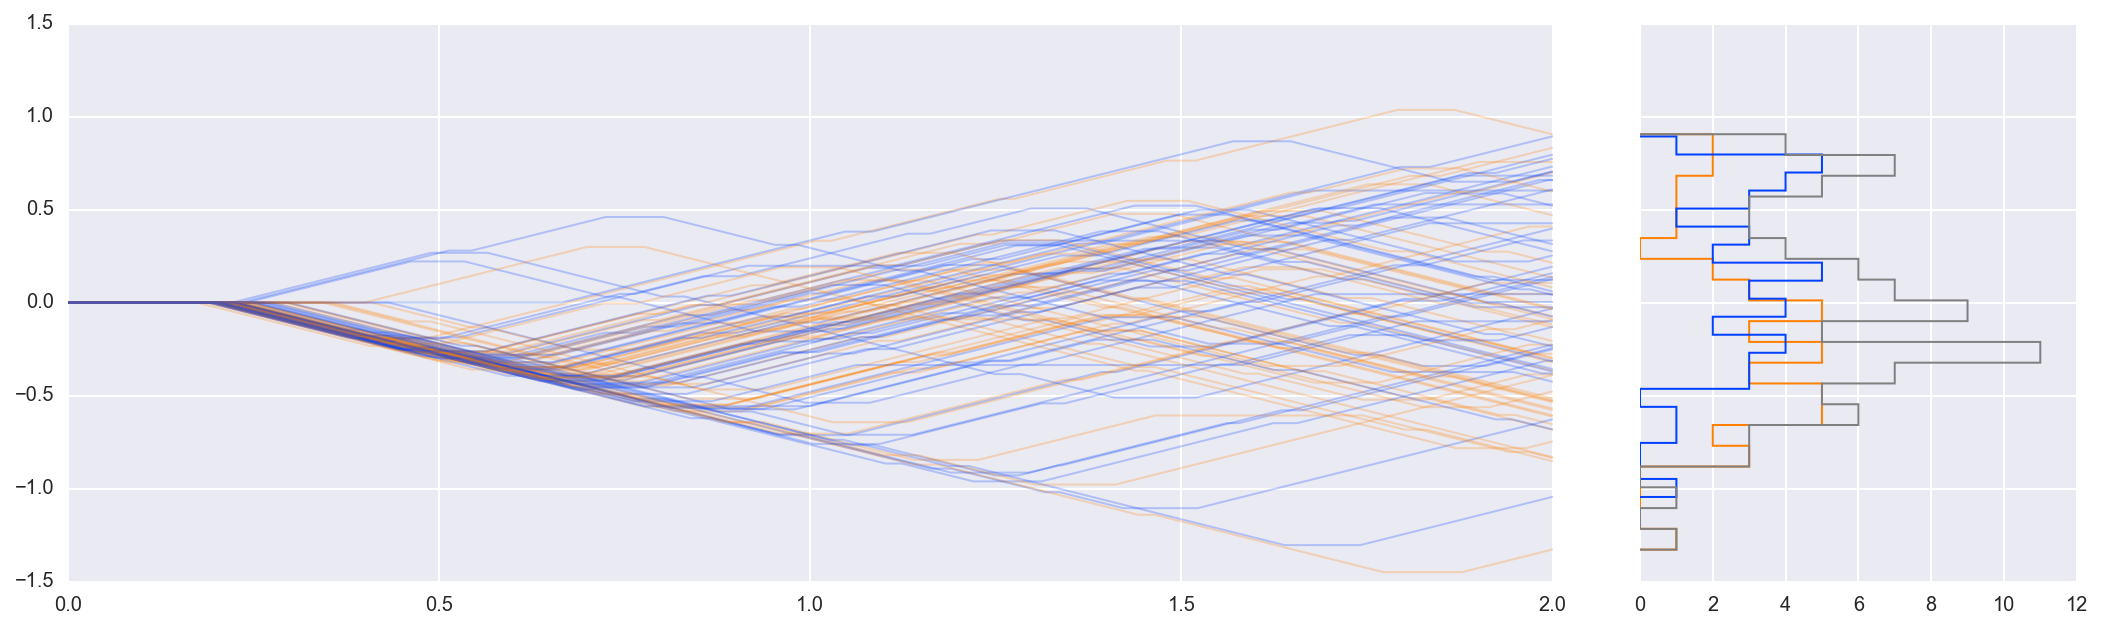

In [9]:
nsamp    = 2000
timemax  = 2.0
timeline = np.linspace(0,timemax,nsamp)
nbins    = 20
plt.figure(figsize = (18,5))
gs  = gridspec.GridSpec(1, 4)

colorspec = [[1,0.5,0],[0,0.25,1]]
ax1 = plt.subplot(gs[0,0:3])
dataall = []
respall = []

for itrial in trial:
    index = np.where(trialall==itrial)[1]
    resp  = sbjtbl['respond'][index[0]] - 1
    scanpath = np.zeros(nsamp)
    for ij in index:
        onset   = sbjtbl['time_start'][ij]
        offset  = sbjtbl['time_end'][ij]
        sampon  = np.where(onset > timeline)[0][-1]
        if offset >= timemax:
            sampoff = nsamp
        else:
            sampoff = np.where(offset < timeline)[0][0]
        scanadd = np.linspace(0,sbjtbl['fixdur'][ij],sampoff-sampon)
        scanpath[sampon:sampoff] = scanpath[sampon:sampoff] + loc[ij]*scanadd
        scanpath[sampoff:]       = scanpath[sampoff:] + loc[ij]*scanadd[-1]
    ax1.plot(timeline,scanpath,lw = 1,color=colorspec[resp],alpha = .25)
    dataall.append([scanpath[-1]])
    respall.append([resp])
    
dataall = np.asarray(dataall)
respall = np.asarray(respall)

ax2 = plt.subplot(gs[0,3],sharey=ax1)
for i in range(2):
    ax2.hist(dataall[respall==i],bins=nbins,normed=False,\
             orientation='horizontal',histtype='step',lw = 1,color=colorspec[i])
ax2.hist(dataall, bins=nbins,normed=False,orientation='horizontal',histtype='step',lw = 1,color='grey')
plt.setp(ax2.get_yticklabels(), visible=False)

plt.show()